In [67]:
import os, sys
import glob
import re
import pickle

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('seaborn-v0_8-whitegrid')

sys.path.append(os.path.abspath('..'))
import function

In [68]:
def bins_divide(data, relative_data, bins_num):
    bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
    bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

    bins_dis = []
    bins_mean = []
    bins_id_data = np.digitize(data, bins_interval) - 1

    for i in range(0, bins_num):
        index_divide = bins_id_data == i
        bins_dis.append(np.std(relative_data[index_divide]))
        bins_mean.append(np.mean(relative_data[index_divide]))

    return bins_center_interval, bins_mean, bins_dis

def reverse_color(color):
    # 去掉颜色值中的'#'符号
    color = color.lstrip('#')

    # 解析RGB值
    r = 255 - int(color[0:2], 16)
    g = 255 - int(color[2:4], 16)
    b = 255 - int(color[4:6], 16)

    # 格式化为新的颜色值
    new_color = "#{:02X}{:02X}{:02X}".format(r, g, b)

    return new_color

In [69]:
band = 'g'
cof_xy = 1
cof_mag = 3

path = "../match_res/"
fits_files = glob.glob(os.path.join(path, f'*{band}*{cof_xy}_{cof_mag}.pkl'))
fits_files = sorted(fits_files, key=lambda x: int(x.split("_")[-3]))
exp_times = [fits_file.split("_")[-3] for fits_file in fits_files]

In [70]:
colors = ['#DF7A5B', '#78BC78', '#32325B', '#A40545', '#FDB32E']
reverse_colors = []
for color in colors:
    reverse_colors.append(reverse_color(color))

In [71]:
mag_list = []
bins_centers_mag_list = []
bins_std_dis_ra_list = []
bins_std_dis_dec_list = []

for i, fits_file in enumerate(fits_files):
    with open(fits_file, 'rb') as f:
        data = pickle.load(f)
        
    match_mag = data["MAG"]
    match_x = data["X_IMAGE"]
    match_y = data["Y_IMAGE"]
    dis_ra = data["DIS_RA"]
    dis_dec = data["DIS_DEC"]

    dis_ra, dis_dec, match_mag, filter = function.sigma_filter_2(dis_ra, dis_dec, match_mag, 3)
    index_mag = (match_mag < 29) & (match_mag > 15)

    dis_ra = dis_ra[index_mag]
    dis_dec = dis_dec[index_mag]
    match_mag = match_mag[index_mag]
    
    bins_divide_num = 5
    bins_centers_mag, bins_mean_dis_ra, bins_std_dis_ra = bins_divide(match_mag, dis_ra, bins_divide_num)
    bins_centers_mag, bins_mean_dis_dec, bins_std_dis_dec = bins_divide(match_mag, dis_dec, bins_divide_num)

    mag_list.append(match_mag)
    bins_centers_mag_list.append(bins_centers_mag)
    bins_std_dis_ra_list.append(bins_std_dis_ra)
    bins_std_dis_dec_list.append(bins_std_dis_dec)

# plt.plot(bin_centers_mag, bins_std_dis_ra)

# ax.set_xlabel(f'Mag.', fontsize=11)
# ax.set_ylabel(r'$\Delta$X (mas)', fontsize=11)
# plt.legend(loc='upper left', title='exposure time')

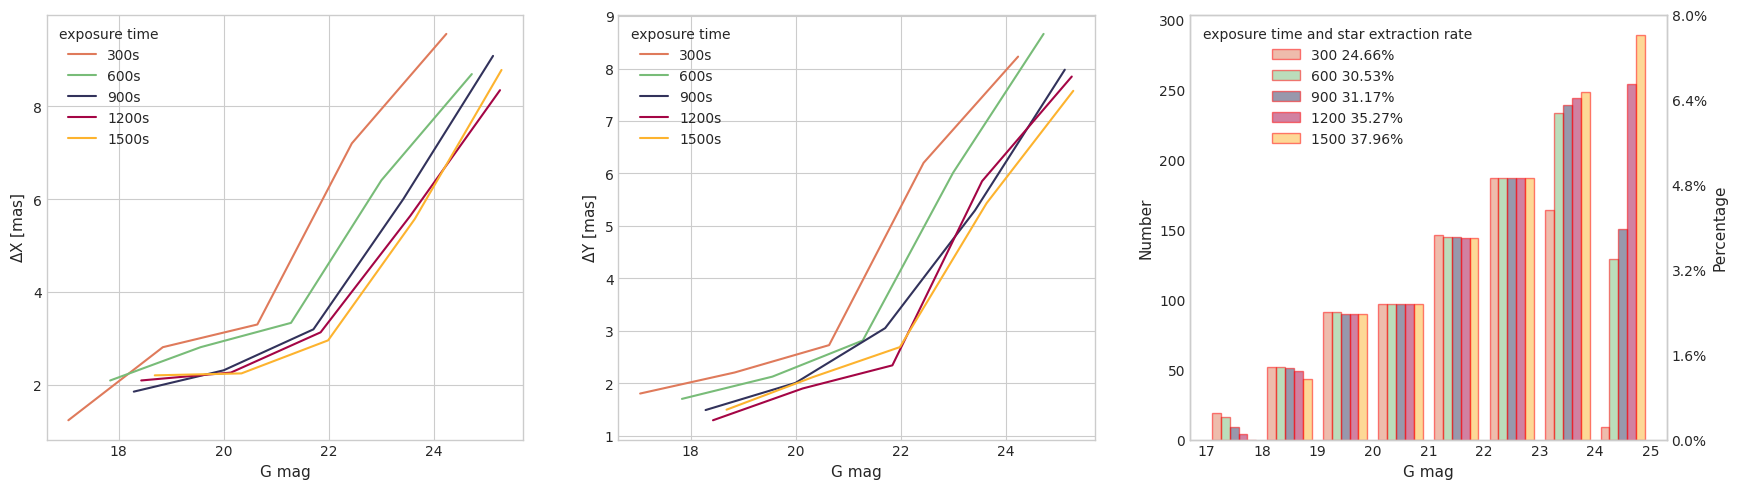

In [72]:
fig = plt.figure(num=1, figsize=(18, 5))
ax = fig.add_subplot(1, 3, 1)

for i, fits_file in enumerate(fits_files):

    plt.plot(bins_centers_mag_list[i], bins_std_dis_ra_list[i], label=f'{exp_times[i]}s', color=colors[i])

ax.set_xlabel(f'{band.upper()} mag', fontsize=11)
ax.set_ylabel(r'$\Delta$X [mas]', fontsize=11)
plt.legend(loc='upper left', title='exposure time')

ax = fig.add_subplot(1, 3, 2)

for i, fits_file in enumerate(fits_files):

    plt.plot(bins_centers_mag_list[i], bins_std_dis_dec_list[i], label=f'{exp_times[i]}s', color=colors[i])

ax.set_xlabel(f'{band.upper()} mag', fontsize=11)
ax.set_ylabel(r'$\Delta$Y [mas]', fontsize=11)
plt.legend(loc='upper left', title='exposure time')

ax = fig.add_subplot(1, 3, 3)
ax_twin = ax.twinx()
bin_edges = [17, 18, 19, 20, 21, 22, 23, 24, 25] if band == 'g' else [19, 20, 21, 22, 23, 24, 25, 26, 27]

# exp_time = [f"{exp_t} {round(len(mag_c) / num_stars * 100, 2)}%" for exp_t, mag_c in zip(exp_time, mag_c_list)]
num_stars = 3122
exp_time_extract = [f"{exp_t} {round(len(mag_c) / num_stars * 100, 2)}%" for exp_t, mag_c in zip(exp_times, mag_list)]
num_bins, bins, _ = ax.hist(mag_list, bins=bin_edges, edgecolor="r", histtype="bar", color=colors, alpha=0.5, label=exp_time_extract)
# ax.set_xlabel(f'{chr(ord(band) - 32)} Mag.', fontsize=11)
ax.set_xlabel(f'{band.upper()} mag', fontsize=11)
ax.set_ylabel('Number', fontsize=11)
ax.grid(False)
ax.legend(loc='upper left', title='exposure time and star extraction rate')

ax_twin.set_ylabel(r'Percentage', fontsize=11)
# custom_labels = np.round(np.arange(0, 250, 50) / num_stars * 100, 2)  # g
# custom_labels = np.round(np.arange(0, 800, 100) / num_stars, 2)  # i, r
# ax_twin.set_yticks(ticks=np.arange(0, 100, 100 / len(custom_labels)), labels=custom_labels)

band_to_max_stars = {'g': 250, 'r': 782, 'i': 700}
num_stars_bin_max = band_to_max_stars.get(band)

ax_twin.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=num_stars / num_stars_bin_max, decimals=1))
ax_twin.grid(False)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95)
plt.show()
fig_path = "./sta_band/"
fig_name = f"sta_{band}_0614.png"
# plt.savefig(os.path.join(fig_path, fig_name), dpi=600)
